In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,5980,6240,5980,6240,50,VMD
1,1,2014-01-03,6240,6240,6240,6240,100,VMD
2,2,2014-01-06,6340,6340,6340,6340,860,VMD
3,3,2014-01-07,6340,6340,6340,6340,0,VMD
4,4,2014-01-08,6090,6340,6090,6340,200,VMD
...,...,...,...,...,...,...,...,...
2472,2472,2023-12-04,20300,20300,19700,20300,238300,VMD
2473,2473,2023-12-05,20300,20900,19750,19900,62700,VMD
2474,2474,2023-12-06,20300,20600,20100,20150,51500,VMD
2475,2475,2023-12-07,20150,20300,20000,20150,41100,VMD


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 8:1:1
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 8:1:1
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44679.827, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42018.438, Time=0.85 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31629.969, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31616.395, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31616.291, Time=0.73 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=31616.862, Time=0.56 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31619.750, Time=1.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=31614.361, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31613.281, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=39756.045, Time=6.87 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=31614.407, Time=0.75 sec
 ARIMA(0,0,3)(0,0,0)[0]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1981
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -15799.003
Date:                Sat, 16 Dec 2023   AIC                          31608.007
Time:                        14:57:17   BIC                          31635.963
Sample:                             0   HQIC                         31618.277
                               - 1981                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    108.0748     35.632      3.033      0.002      38.238     177.912
ar.L1          0.9939      0.001    956.640      0.000       0.992       0.996
ma.L1          0.2533      0.009     28.218      0.000       0.236       0.271
ma.L2          0.0986      0.010      9.925      0.000       0.079       0.118
sigma2      4.952e+05   6628.294     74.710      0.000    4.82e+05    5.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8881.35
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               4.09   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(1,0,2),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1981
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -13907.717
Date:                Sat, 16 Dec 2023   AIC                          27831.434
Time:                        14:57:18   BIC                          27876.165
Sample:                             0   HQIC                         27847.866
                               - 1981                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.6370     13.710      3.547      0.000      21.765      75.509
high           0.8214      0.006    129.528      0.000       0.809       0.834
open          -0.5820      0.005   -109.151      0.000      -0.592      -0.572
low            0.7582      0.005    153.238      0.000       0.749       0.768
ar.L1          0.6102      1.268      0.481      0.630      -1.874       3.095
ma.L1         -0.5851      1.269     -0.461      0.645      -3.073       1.902
ma.L2         -0.0086      0.042     -0.204      0.838      -0.091       0.074
sigma2      7.359e+04    874.153     84.189      0.000    7.19e+04    7.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26010.63
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.51   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  356.36693523447764
MAPE:  1.5149300725963422
RMSE:  484.9183870766892

** Validate **
MAE:  216.10868861446133
MAPE:  1.0025212516143438
RMSE:  302.07782662407186


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-526:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2477    18453.349118
2478    17914.741280
2479    17078.790868
2480    16495.567920
2481    16422.603426
2482    16134.458257
2483    16030.577654
2484    15580.456836
2485    15497.352354
2486    15830.885855
2487    16825.157611
2488    16743.537932
2489    16448.290792
2490    16540.096536
2491    16535.305435
2492    16292.717960
2493    16619.633208
2494    16822.603313
2495    16609.117220
2496    16820.110655
2497    16955.465153
2498    16597.331865
2499    16305.452115
2500    16579.048402
2501    17410.980935
2502    19002.088147
2503    19843.978881
2504    20374.711525
2505    20393.672919
2506    20158.745202
Name: predicted_mean, dtype: float64


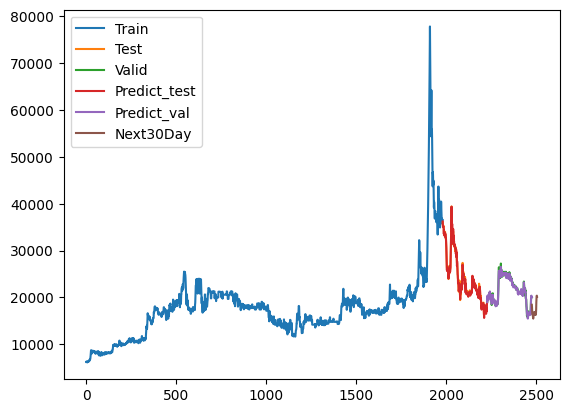

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()